## 1. Importing libraries

In [1]:
# Classics
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

%cd ..

/home/mluser/projects/Keywork-Extraction-Kaggle-Stackoverflow


In [23]:
!du -hs ./input

8.9G	./input


### 1.1 Utility functions

Use the following commands to download or upload data to connected blob storage
 
__Download__
```python
filename = "SampleSubmission.csv"
%run ./src/blob_handle.py --operation "download" --filename $filename
```
 
__Upload__
```python
filename = "SampleSubmission.csv"
%run ./src/blob_handle.py --operation "upload" --filename $filename
os.remove(f"./input/{filename}")
``` 

  
> _All files have been set for auto-delete after 20 days_


### 1.2 Library for data manipulation

Since we are handling data which is nearly 5 to 6 Gb in size. It is not possible to use pandas as it runs all the operations on a
single thread. We need multicore support. Below are few libraries that feature this:
1. Dask - A library to enable multiple processes and multithreading to superspeed workflows. This can also make use of computing clusters if available. It supports out of memory computations.
2. Datatable - It is a library with strong emphasis on speed and closely resemble the data.table library in R language. The syntax is very different from pandas so there is a learning curve involved.
3. Modin - It uses engine like Dask behind the scene but mirrors pandas API, so you can run a lot of pandas code without any changes.

I have tried and tested all three, Dask and Modin often throw errors so you spend more time debugging than doing useful work.


## 2. Reading data

In [5]:
import os

for file in os.listdir("./input"):
    _ = os.stat(os.path.abspath("./input/"+file)).st_size / 1024 / 1024
    print(f"File name : {file} and file size is {_:.2f} MB")

File name : Train_no_duplicates.csv and file size is 4858.05 MB
File name : tags_vectorized_top50_tags.pickle and file size is 401.60 MB


_We have two files in the input for started, each one of them above 1 GB. In order to make the analysis easier to run on computer, <b>we will only be using the train file</b> for which we have the answers avaialable. For the test file, the predictions need to be submitted on kaggle, so it is of no use for the initial analysis_

In [6]:
import datatable
from datatable import by, dt, f

if not os.path.exists("./input/Train_no_duplicates.csv"):
    data = datatable.fread("./input/Train.csv", encoding="utf-8")
    
    # upload to blob storage and remove from local to save space
    filename = "Train.csv"
    %run ./src/blob_handle.py --operation "upload" --filename $filename
    print("Removing file from local")
    os.remove(filename)
    
else:
    print("Processed dataset is being loaded")
    data_no_dupes =datatable.fread("./input/Train_no_duplicates.csv", encoding="utf-8")

Processed dataset is being loaded


---
 
> __`Skip execution of some cells below if processed dataset is loaded`__
---

In [5]:
print(data.shape)

data.head(5)

(6034195, 4)


,Id,Title,Body,Tags
,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪
0,1,How to check if an uploaded file is an image witho…,<p>I'd like to check if an uploaded file is an ima…,php image-processing file-upload upload mime-types
1,2,How can I prevent firefox from closing when I pres…,"<p>In my favorite editor (vim), I regularly use ct…",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a data fr…,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply cann…",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......) { $mcontact …,php api file-get-contents


As we can wee, there are 3 key columns:
* Title - this is the title of the question posted on SO
* Body - contains the body including the code snippets etc
* Tags - the tags that we want to predict for new questions

Here are few key observations:
1. There are over 6 million questions in the training datasets
2. With Dask, very less data sits in RAM

### 3.1 Visualize a few question examples

In [7]:
import IPython
#import ipywidgets as widgets

if not os.path.exists("./input/Train_no_duplicates.csv"):
    xhead = data[:100, :].to_pandas()
else:
    xhead = data_no_dupes[:100, :].to_pandas()

#@interact(i = (1, 10))
def fun(i):
    return IPython.display.HTML(f"<h3>Label</h3><h4><code>{xhead.Tags[i].split()}</code></h4><hr>" \
                                + f"<h2>{xhead.Title[i]}</h2>"\
                                    + xhead.Body[i])

fun(53)

## 3. Removing duplicate questions and deep-dive

Since this is a questions database, there is quite a possibility that one question is posted more than once 
by the same user. So, we want to remove all such duplicates

In [7]:
data.names

('Id', 'Title', 'Body', 'Tags')

In [ ]:
from datatable import dt, f, by, count, sum, unique

data_no_dupes = data[:, {'count_duples': dt.count()}, by(f.Title, f.Body, f.Tags)]

dt.unique(data_no_dupes["count_duples"])

`As we can see above, a question can be repeated upto six times`

In [9]:
# Save the dataframe for use later

data_no_dupes.to_csv("./input/Train_no_duplicates.csv")

!ls ./input

SampleSubmission.csv  Test.csv	Train.csv  Train_no_duplicates.csv


In [10]:
# Remove the first dataframe to free some memory

del data

### 3.1 Visualize question pair duplications

As we can see from the output above, questions are repeated upto six times. But it will be interesting to analyse the distribution of the duplications over 6 million questions. 
 
We will try to dig deep and understand how many questions repeat, and what is the size of new dataframe after reducing the duplicated

In [6]:
from datatable import dt, f, by, count, sum

dup_groups = data_no_dupes[:, {"count": dt.count()}, by('count_duples')]

dup_groups

,count_duples,count
,▪▪▪▪,▪▪▪▪▪▪▪▪
0,1,2656283
1,2,1272336
2,3,277575
3,4,90
4,5,25
5,6,5


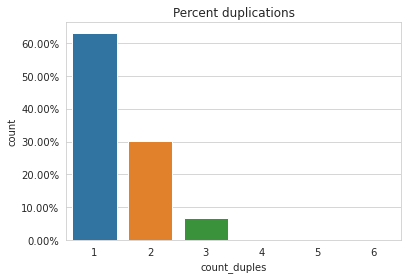

In [7]:
sns.set_style("whitegrid")

# convert count to proportion
dup_groups[:, dt.update(count = f.count / dt.sum(f.count))]

ax = sns.barplot(x = "count_duples", y = "count", data = dup_groups.to_pandas())
_ = ax.get_yticks()
ax.set_yticklabels([f"{i:.2%}" for i in _])
plt.title("Percent duplications")
plt.show()

This goes to show that:
1. There were 2 million duplicates in the dataset, or __35 percent__
2. Around 30 percent of the questions had at least 1 duplicate
3. Very few, around 4 percent, of the questions had 2 or more duplicates

In [9]:
print(f"Total duplicate questions: {6034195 - data_no_dupes.shape[0]}")

Total duplicate questions: 1827881


There were around 2 million duplicate questions in the database

In [ ]:
# Lets get rid of the dataset with duplicates

del data

Now, we only have the data without any duplicate questions for further analysis

## 4. Analyzing tags

We will now try to analyse the tags associated with the questions by answering the below questions:
About tags:
1. Top occuring tags
2. Visualise the tags in the data
Tag distribution:
1. Number of tags for various questions in dataset
2. Distribution of the #tags in the dataset
3. How many tags do the majority of questions have ?

#### 4.1 Vectorizing the tags

In [8]:
# Tags that we will featurize
import pickle
import os

tags = data_no_dupes[:, ["Tags"]].to_list()[0]

# If the file has already been created then read it
if not os.path.exists(os.path.join("input", "tags_vectorized.pickle")):
    # We will use Dask ML for vectoring the dataset we have
    from dask_ml.feature_extraction.text import CountVectorizer
    import dask.bag as bag

    from dask.distributed import Client
    client = Client(n_workers = 12)

    corpus = bag.from_sequence(tags, npartitions=20)

    # create vectorizer
    vectorizer = CountVectorizer(tokenizer= lambda x: x.split()) # split using space
    X = vectorizer.fit_transform(corpus)

    # Fit the count vectorizer to the data
    result = X.compute()
    names = vectorizer.get_feature_names()
    
    client.close()

    # save the results
    print("Saving the results now")
    pickle.dump([result, names], open("./input/tags_vectorized.pickle", "wb"))
else:
    print("Loading existing file")
    result, names = pickle.load(open("./input/tags_vectorized.pickle", "rb"))

distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Saving the results now


`It took around 6 minutes to vectorize the entire dataset`

In [9]:
result

<4206314x42048 sparse matrix of type '<class 'numpy.int64'>'
	with 12195954 stored elements in Compressed Sparse Row format>

> Result is stored as a sparse array to reduce the size and memory consumption on disk. 
>> Till now total memory consumed is 20 GB

The dataset has a total of 42000 unique labels.

- 4.2 million questions
- 42000 unique possible tags for each question

#### 4.2 Number of tags analysis

In [6]:
_ = result.sum(axis=0).tolist()[0]
_[:10]

[18, 37, 1, 21, 138, 53, 14, 47, 1, 8]

In [7]:
tagfreq = datatable.Frame(tag = names, freq = _).sort(-f.freq)
tagfreq[:, dt.update(prop = f.freq / dt.sum(f.freq))]
tagfreq.head(4)

,tag,freq,prop
,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪
0,c#,331505,0.0271816
1,java,299414,0.0245503
2,php,284103,0.0232949
3,javascript,265423,0.0217632


#### 4.3 Barplot of word freq

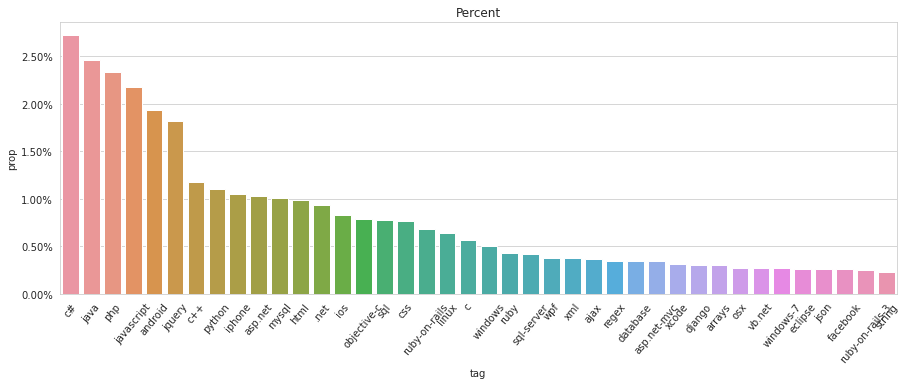

In [12]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(111)

sns.barplot(x = "tag", y = "prop", data=tagfreq[:40, :].to_pandas())
plt.xticks(rotation = 50)
_ = ax.get_yticks()
ax.set_yticklabels([f"{i:.2%}" for i in _])
plt.title("Percent")
plt.show()

In [13]:
tagfreq.tail(5)

,tag,freq,prop
,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪
0,zone-focus,1,8.19944e-08
1,zope.component,1,8.19944e-08
2,zstream,1,8.19944e-08
3,zumero,1,8.19944e-08
4,zzt-oop,1,8.19944e-08


`Java, net, jquery`  are amongst the top tags in the dataset. There are tags which have used only once. __Used in around 400k documents.__
 
It is not possible to predict such tags from the dataset for which there is not enough data available


#### 4.4 Wordcloud of tags

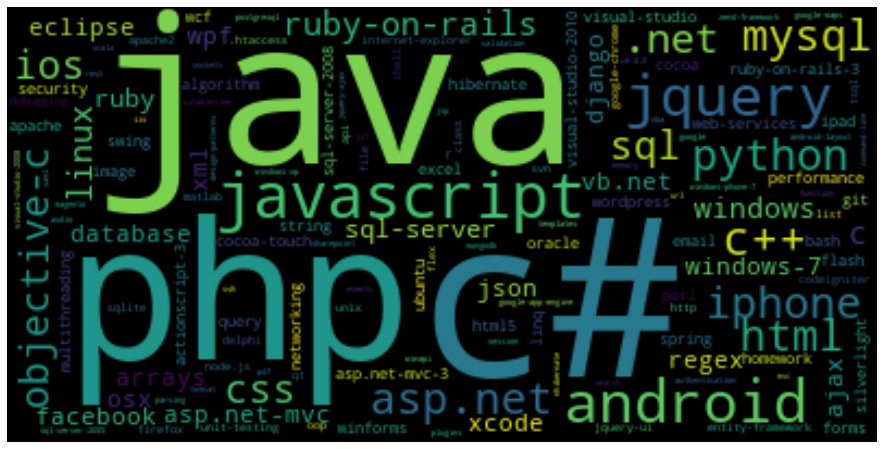

In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Dictionery of word and their frequencies
_ = tagfreq.to_list()
dict_freq = {}
for i, j in zip(_[0], _[1]):
    dict_freq[i] = j

# creating the wordcloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(dict_freq)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


`Above` we can see all the different tags scaled by the frequency of their use across the documents

#### 4.5 Plotting tag freq

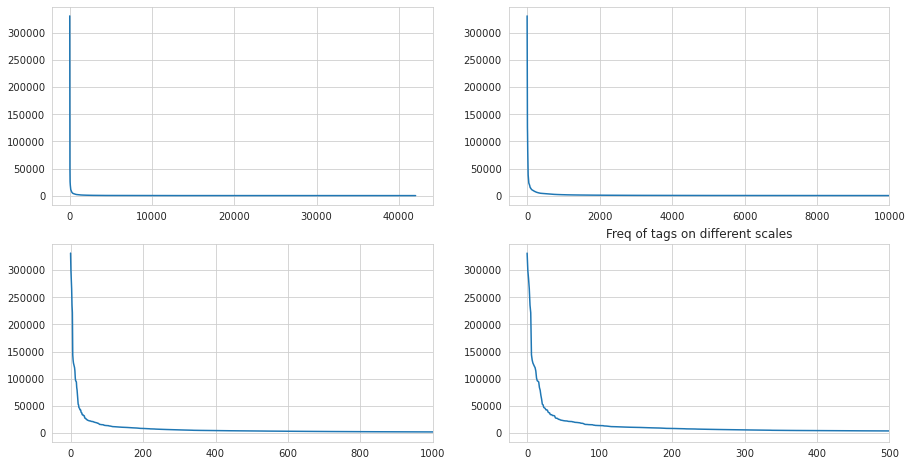

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 8), sharex = False, sharey = False)

x = tagfreq[:, ["freq"]].to_list()[0]

# All tags
ax1.plot(x)
ax2.set_xlim([-500, 40000])

# upto first 10k most frequent
ax2.plot(x)
ax2.set_xlim([-500, 10000])

# upto first 1000 most frequent
ax3.plot(x)
ax3.set_xlim([-50, 1000])

ax4.plot(x)
ax4.set_xlim([-25, 500])

plt.title("Freq of tags on different scales")
plt.show()

`From what we see above`, most of the tags have very less freq compared to the frequently occuring tags.
> Or, in other words, compared to the frequent tags, less frequent tags have little data to make predictions about !

In [16]:
tagfreq.head(5)

,tag,freq,prop
,▪▪▪▪,▪▪▪▪,▪▪▪▪▪▪▪▪
0,c#,331505,0.0271816
1,java,299414,0.0245503
2,php,284103,0.0232949
3,javascript,265423,0.0217632
4,android,235436,0.0193044


##### 4.6 Zoom in on the first 100 most frequent tags

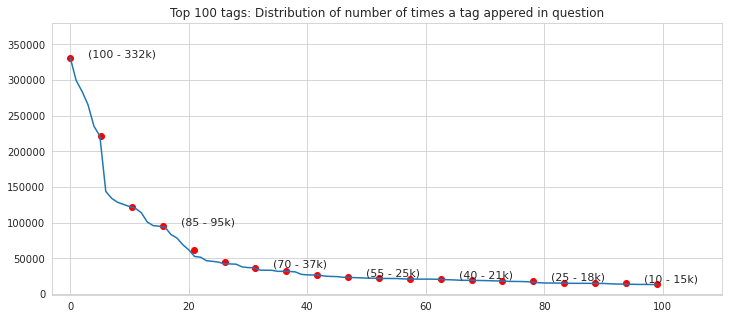

In [17]:
plt.figure(figsize = (12, 5))

tile = 5
xmax = 100

qx = np.linspace(0, xmax-1, len(range(100, 0, -tile)) )
qy = np.percentile(x[:xmax], range(100, 0, -tile), interpolation = "lower")

plt.scatter(qx, qy, color = "red")
plt.plot(x[:xmax])

k = 100
for i, j in zip(qx[::3], qy[::3]):
    plt.annotate(f"({k:.0f} - {j/1000:.0f}k)", xy = (i, j), xytext = (i+3, j+1000), fontsize = 11)
    k = k - tile*3

plt.xlim(-3, xmax+10)
plt.ylim(-1000, 380000)
plt.title(f"Top {xmax} tags: Distribution of number of times a tag appered in question")
plt.show()

In [18]:
## tags used 10k times
print("#1 tags used 10k times. ", tagfreq[f.freq > 10000, :].shape[0])

## tags used 100k times
print("#2 tags used 100k times. ", tagfreq[f.freq > 100000, :].shape[0])

## most frequent
print("#3 Most freqent tag ", tagfreq[0, [f.tag, f.freq]].to_list())

#1 tags used 10k times.  153
#2 tags used 100k times.  14
#3 Most freqent tag  [['c#'], [331505]]


Observations - 
1. Only 14 tags occur at least 100k times
2. Only 153 tags occue at least 10k times
3. Most frequent tag occurs 300k times

#### 4.7 Coverage

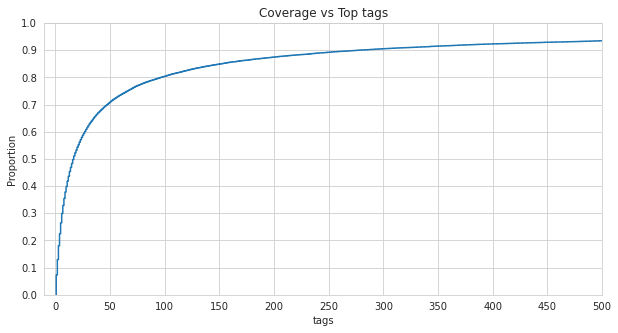

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.ecdfplot(x)
plt.xlabel("tags")
plt.yticks([i/10 for i in range(11)])
plt.xticks(range(0, 501, 50))
plt.xlim(-10, 500)
plt.title("Coverage vs Top tags")
plt.show()

This plot most certainly tells that:
1. Predicting __top 500 tags__ will give a coverage over __90 percent__ of the questions in dataset
2. Predicting only __top 100 tags__ will give us coverage over __80 percent__ of the questions
3. Predicting only __top 50 tags__ gives coverage over __70 percent__ of all questions in dataset 

## 5. Filtering the data for __Top 50 Tags__

In the below section, we will trim down the data based on new findings: `coverage using top 50 tags is 70 percent of data`

### 5.1 Create count vectorized matrix for top 50 tags
__4 million questions x 50 tags__

In [10]:
# Create dense result matrix for the top 50 features

# If the file has already been created then read it
if not os.path.exists(os.path.join("input", "tags_vectorized.pickle")):

    top_50_tags = tagfreq[:50, ["tag"]].to_list()[0]

    result_50_tags = []
    names_50_tags = []

    for tag in top_50_tags:
        tag_index = names.index(tag)
        #res = delayed(result.getcol)(tag_index).todense()
        res = result.getcol(tag_index).todense().flatten().tolist()[0]

        names_50_tags.append(tag)
        result_50_tags.append(res)

    # save the results
    print("Saving the results now")
    pickle.dump([result_50_tags, names_50_tags], open("./input/tags_vectorized_top50_tags.pickle", "wb"))
else:
    print("Loading existing file")
    result_50_tags, names_50_tags = pickle.load(open("./input/tags_vectorized_top50_tags.pickle", "rb"))

Loading existing file


In [12]:
# convert to datatable format

tags_vectorized_top_50 = datatable.Frame(result_50_tags, names = names_50_tags)
tags_vectorized_top_50 = tags_vectorized_top_50[:, f[:].extend({'#tags': dt.rowsum(f[:])})]
tags_vectorized_top_50.head(2)

,c#,java,php,javascript,android,jquery,c++,python,iphone,asp.net,…,image,html5,networking,homework,#tags
,▪,▪,▪,▪,▪,▪,▪,▪,▪,▪,,▪,▪,▪,▪,▪▪▪▪
0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,0,…,0,0,0,0,1


In [13]:
# Number of questions which donot have any tags in the top 50 tags

tags_vectorized_top_50[f["#tags"] == 0, :].shape

(1323436, 51)

`From above`, we understand that out of the 4 million questions, 1.3 million donot have tags in __Top 50__ tags, so they can be excluded from the data

In [14]:
data_no_dupes_top50 = data_no_dupes[:, f[:].extend(tags_vectorized_top_50)][f["#tags"] != 0, :]

print(data_no_dupes_top50.shape)

data_no_dupes_top50.head(2)

(2882878, 55)


,Title,Body,Tags,count_duples,c#,java,php,javascript,android,jquery,…,image,html5,networking,homework,#tags
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪,▪▪▪▪,▪,▪,▪,▪,▪,▪,,▪,▪,▪,▪,▪▪▪▪
0,Implementing Boundary Value Analysis of Softw…,<pre><code>#include&lt;iostream&gt; #include&lt;st…,c++ c,1,0,0,0,0,0,0,…,0,0,0,0,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamically at…,c# silverlight data-binding,1,1,0,0,0,0,0,…,0,0,0,0,1


`Now`, we are left out with only 2.8 million questions after the thorough analysis on question tags

In [15]:
# Save the results

data_no_dupes_top50.to_csv("./input/data_no_dupes_top50.csv")

In [16]:
# Load results

data_no_dupes_top50 = datatable.fread("./input/data_no_dupes_top50.csv")

In [19]:
data_no_dupes_top50.shape

(2882878, 55)

`Until now`, the __tag data__ has been cleaned and is now ready for further analysis.<br><br>
Next steps, broadly - 
1. Process title and body to create features
2. Apply multilabel logistic regression to the dataset
3. Evaluate results

Before moving on to the text processing part, we want to analyse one last thing about the tags. The ratio of tags that are set for overall dataset.<br>
## 5.2 Tag proportions

In [94]:
_ = data_no_dupes_top50[:, f[:].remove(f.count_duples)][:, tags_vectorized_top_50.names[:-1]]
_.head(2)

,c#,java,php,javascript,android,jquery,c++,python,iphone,asp.net,…,asp.net-mvc-3,image,html5,networking,homework
,▪,▪,▪,▪,▪,▪,▪,▪,▪,▪,,▪,▪,▪,▪,▪
0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0


In [96]:
_[:, dt.sum(f[:])]

,c#,java,php,javascript,android,jquery,c++,python,iphone,asp.net,…,asp.net-mvc-3,image,html5,networking,homework
,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,331505,299414,284103,265423,235436,221533,143936,134137,128681,125651,…,24537,23585,23230,23083,22747


In [100]:
_res = dt.rbind(_[:, dt.sum(f[:])], _[:, dt.count(f[:])])
_res_pd = _res.to_pandas().T.reset_index().rename(columns = {0: "occur", 1: "total", "index": "tag"})
_res_pd = _res_pd.assign(no_occur = _res_pd.total - _res_pd.occur, prop = _res_pd.occur / _res_pd.total)
_res_pd.head()

,tag,occur,total,no_occur,prop
0,c#,331505,2882878,2551373,0.114991
1,java,299414,2882878,2583464,0.103859
2,php,284103,2882878,2598775,0.098548
3,javascript,265423,2882878,2617455,0.092069
4,android,235436,2882878,2647442,0.081667


In [101]:
_res_pd_melt = pd.melt(_res_pd, id_vars = "tag", value_vars=["occur", "no_occur"])

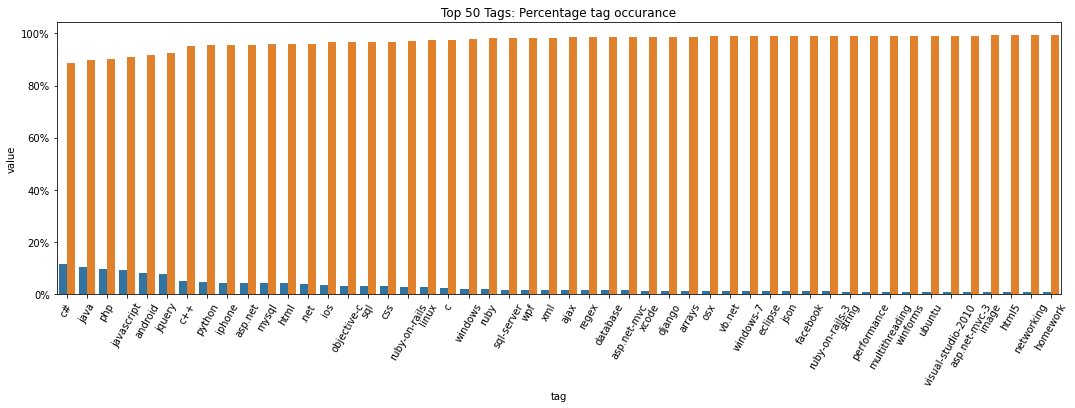

In [125]:
plt.figure(figsize=(18, 5))
ax = sns.barplot(data = _res_pd_melt.assign(value = lambda r: r.value / 2882878), x = "tag", y = "value", hue="variable")
plt.xticks(rotation=60)
_ = ax.get_yticks()
ax.set_yticklabels([f"{i:.0%}" for i in _])
leg = plt.legend()
leg.remove()
plt.title("Top 50 Tags: Percentage tag occurance")
plt.show()

`From above`, it can be clearly inferred that our data is highly imbalanced. So, we need to employ techniques to curb any side effects from having such a highly imbalanced dataset.